# Capstone Week 3
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
- [Feature Engineering](#Feature-Engineering)
    - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
- [Residuals](#Residuals)
- [Classification](#Classification)
- [Model Interpretation](#Model-Interpretation)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [13]:
df = pd.read_csv("../Transactions.csv", parse_dates=['refresh_date'])

In [14]:
df.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M,redemption_curr,redemption_12M,new_Fund_added_12M,redemption_rate,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date
0,85102111664960504040,3096,6592,302,157,8,13,7,7,2,3,2,2,9,2,1.909702e+07,399995.834888,1.259993e+07,-231714.43334,-6.557185e+06,0,-0.012133,9.386941e+06,9.743856e+06,-9655.913728,0.0,-24116.993988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.431248e+06,1.066578e+07,0.0,0.0,2017-12-31
1,4492101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.468574e+04,0.000000,0.000000e+00,0.00000,0.000000e+00,0,0.000000,-7.102100e+03,0.000000e+00,-7583.640000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.468574e+04,0.000000e+00,0.0,0.0,2017-12-31
2,85102140943881291064,0,1,0,0,0,1,0,0,0,1,0,0,0,0,-7.164047e+04,0.000000,0.000000e+00,0.00000,-1.950000e+02,0,0.000000,-7.164047e+04,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.164047e+04,0.000000e+00,0.0,0.0,2017-12-31
3,85202121774856516280,1,0,0,0,1,0,0,0,1,0,0,0,2,2,3.425462e+05,0.000000,1.164760e+03,0.00000,0.000000e+00,1,0.000000,0.000000e+00,7.030151e+04,272244.700000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.425462e+05,0.000000e+00,0.0,0.0,2017-12-31
4,0360380,7,0,0,0,1,0,0,0,1,0,0,0,2,0,-2.262721e+05,0.000000,3.278145e+03,0.00000,0.000000e+00,0,0.000000,-1.113566e+05,-2.018566e+04,0.000000,0.0,-94729.890000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.315423e+05,-9.472989e+04,0.0,0.0,2017-12-31


In [15]:
# df['refresh_date'].dt.month

# df['year'] = df['refresh_date'].dt.year
# df['month'] = df['refresh_date'].dt.month

# filt = (df['year'] == 2020) & (df['month'] == 11)
# df.loc[filt, :]

## Make advisor dictionary mapper

In [16]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [17]:
adviser_lookup[10]

'0082583'

# Combine `sales_curr` and `sales_12M`

In [18]:
df['total_sales'] = df['sales_curr'] + df['sales_12M']

[Back to Top](#EDA)
# EDA

In [19]:
!conda install -yc conda-forge pandas-profiling

Solving environment: done

# All requested packages already installed.



In [20]:
# from pandas_profiling import ProfileReport

# missing_diagrams = {
#     'heatmap': True, 'dendrogram': True, 'matrix':True, 'bar': True,
# }

# profile = ProfileReport(df, title='Nuveen Profile Report', missing_diagrams=missing_diagrams)

# profile.to_file(output_file="nuveen_profiling.html")

# Data Cleaning

Before you change ANYTHING with the data - besides the above :) - do your train-test split

In [21]:
FEATURES = [
    'CONTACT_ID', 'no_of_sales_12M_1', 'no_of_Redemption_12M_1',
    'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
    'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
    'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
    'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
    'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
    'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M',
    'redemption_rate', 'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 'refresh_date',
]
TARGETS = 'total_sales'

In [22]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'CONTACT_ID', 'sales_curr', 'sales_12M', 
    'refresh_date', 'new_Fund_added_12M','no_of_Redemption_12M_1',
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 
    'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
    'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
    'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
    'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
    'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
    'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'redemption_curr', 
    'redemption_12M', 'redemption_rate', 'aum_AC_EQUITY', 
    'aum_AC_FIXED_INCOME_MUNI', 'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 
    'aum_AC_MULTIPLE', 'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 
    'aum_AC_TARGET', 'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 
    'aum_P_MF', 'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT',
]

## Partition training and testing

In [23]:
training_rows = df['refresh_date'].dt.year.isin([2017, 2018, 2019])
testing_rows = df['refresh_date'].dt.year.isin([2020])

X = df.loc[training_rows, FEATURES].copy()
y_reg = df.loc[training_rows, TARGETS].copy()
y_cl = df.loc[training_rows, 'new_Fund_added_12M'].copy()

y_holdout_test = df.loc[testing_rows, TARGETS].copy() # forget about this for now

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [24]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(series):
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series

## Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [28]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [29]:
def extract_redemption(df):
    redemp_cols = [col for col in df.columns if 'redemption' in col.lower()]
    return df[redemp_cols].copy()

def replace_with_zero(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: min(0, x))
    return df

In [30]:
extract_redemption_trans = FunctionTransformer(extract_redemption)
replace_with_zero_trans = FunctionTransformer(replace_with_zero)

In [31]:
redemption_pipe = Pipeline([
    ('extract_redemption_trans', extract_redemption_trans),
    ('replace_with_zero_trans', replace_with_zero_trans),
    ('StandardScaler', StandardScaler())
])

In [32]:
pd.DataFrame(
    redemption_pipe.fit_transform(X_train),
    index=X_train.index,
    columns=[col for col in X_train.columns if 'redemption' in col.lower()]
)

,no_of_Redemption_12M_1,no_of_Redemption_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_Redemption_12M_10K,redemption_curr,redemption_12M,redemption_rate
122101,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
46186,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
41126,0.0,0.0,0.0,0.0,0.045743,-0.994636,0.004086
30070,0.0,0.0,0.0,0.0,0.067219,0.091516,0.004086
232410,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
...,...,...,...,...,...,...,...
190609,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
216465,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
211136,0.0,0.0,0.0,0.0,0.068414,0.082220,0.004086
899,0.0,0.0,0.0,0.0,0.066797,0.116706,0.004086


In [33]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans)
])

y_train_reg = targ_pipe_reg.fit_transform(y_train_reg)
y_test_reg = targ_pipe_reg.transform(y_test_reg)

Transform the classification target

In [34]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)
y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)
y_test_cl

228198    1
240133    1
163658    1
176954    0
69498     1
         ..
239268    0
116033    0
238773    1
7527      1
11875     0
Length: 75075, dtype: int64

Create the pipeline for the features

In [35]:
from sklearn.preprocessing import PowerTransformer

In [36]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
    ('power_transformer', PowerTransformer())
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [37]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb

### Linear Regression

In [39]:


lr = LinearRegression()
lr.fit(X_train_prepared, y_train_reg)

LinearRegression()

In [40]:
from sklearn.model_selection import cross_validate

In [41]:
-cross_validate(
    lr, 
    X_train_prepared, 
    y_train_reg, 
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)['test_score']

array([1047274.97296997, 1143055.75147174,  989738.79879642])

Make a plot of predictions vs actual

In [42]:
y_test_reg_preds = lr.predict(X_test_prepared)

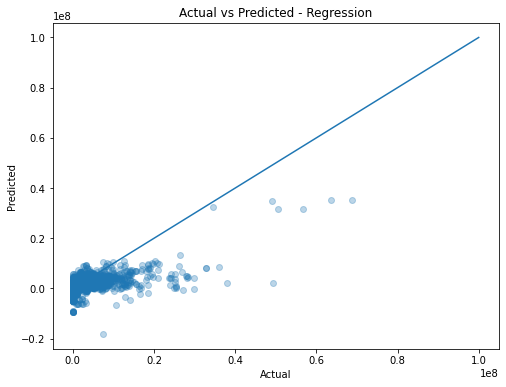

In [43]:
fig, axes = plt.subplots(figsize=(8, 6))

axes.scatter(x=y_test_reg, y=y_test_reg_preds, alpha=0.3)

axes.plot([0, 100000000], [0,100000000])
axes.set_title("Actual vs Predicted - Regression")
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted");

In [44]:
def evaluate_model(model, X, y):
    cvscore=(
        np.mean(
            (-cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])))
    print("Cross Validation Score:\t", cvscore)
    
    print('R-squared:\t', model.score(X, y))
    print('-'*55)
    preds = model.predict(X)
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, lim], [0, lim])
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

Cross Validation Score:	 829025.3242990377
R-squared:	 0.417580491394122
-------------------------------------------------------


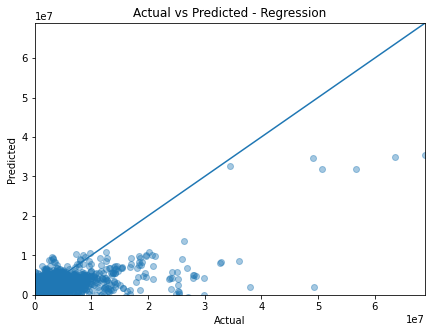

In [45]:
evaluate_model(lr, X_test_prepared, y_test_reg)

In [46]:
from sklearn.ensemble import RandomForestRegressor

### Random Forest

In [47]:
rfr = RandomForestRegressor(n_estimators=5)

In [48]:
rfr.fit(X_train_prepared, y_train_reg)

RandomForestRegressor(n_estimators=5)

Cross Validation Score:	 332097.0330930707
R-squared:	 0.9875958194568739
-------------------------------------------------------


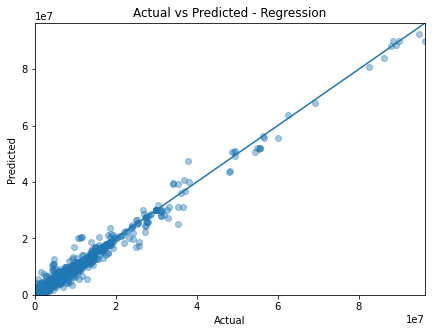

In [49]:
evaluate_model(rfr, X_train_prepared, y_train_reg)

## Classification

In [50]:
y_train_cl

122101    0
46186     0
41126     0
30070     1
232410    0
         ..
190609    0
216465    0
211136    1
899       0
242082    0
Length: 175175, dtype: int64

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_prepared, y_train_cl)

GradientBoostingClassifier()

In [56]:
gbc.predict_proba(X_test_prepared)[:, 1]

array([0.7807657 , 0.53583986, 0.71643784, ..., 0.54576083, 0.89471834,
       0.39478791])

[Back to Top](#Index)
## Residual Analysis

In [57]:
y_test_reg_preds = lr.predict(X_test_prepared)

In [58]:
# get the residuals
residuals = y_test_reg_preds - y_test_reg

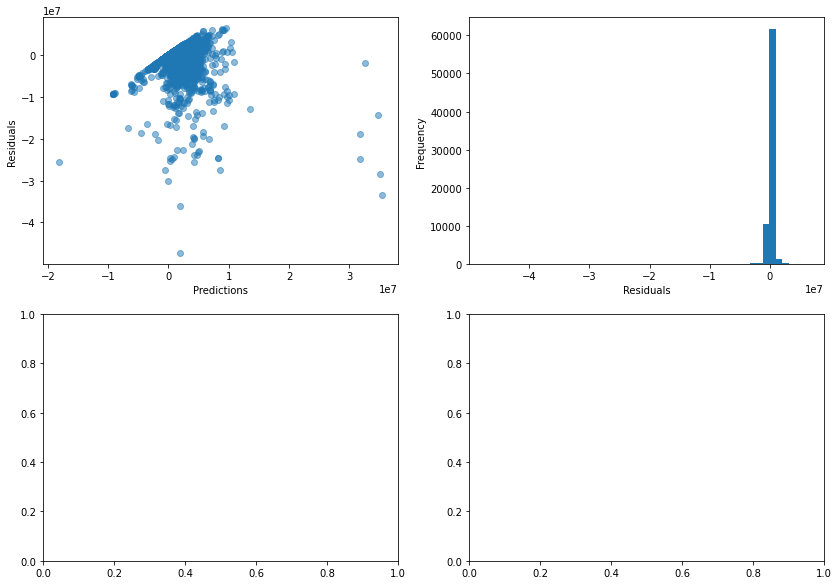

In [59]:
# plot predictions vs residuals
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# plot scatter plot on upper left plot
axes[0,0].scatter(x=y_test_reg_preds, y=residuals, alpha=0.5)
axes[0,0].set(xlabel='Predictions', ylabel='Residuals')

# plot a hist on upper right plot
axes[0,1].hist(residuals, bins=50)
axes[0,1].set(xlabel='Residuals', ylabel='Frequency');

In [62]:
from statsmodels.api import qqplot

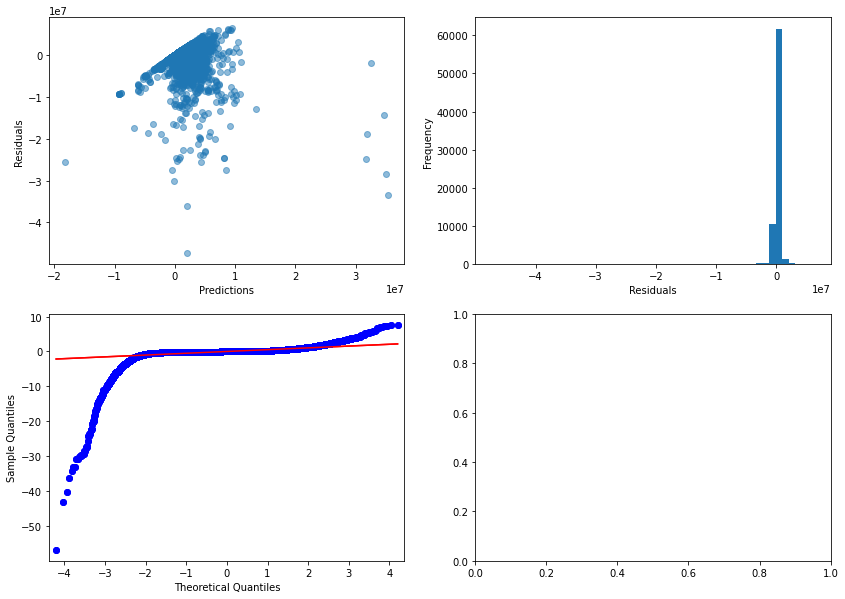

In [63]:
qqplot(residuals, fit=True, line='r', ax=axes[1,0])

In [64]:
y_test_reg_preds

array([ 281037.57952148,   99874.91412377,  115789.61259415, ...,
        786801.65758175,  395754.51832331, -114003.56436889])

In [ ]:
# !pip install scikit-plot

In [65]:
import scikitplot as skplt

In [66]:
def evaluate_classifier(X, y, model):
    pass
    # print classification report
    # create lift charts
    # create gains charts

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# rf = RandomForestClassifier()

# rf.fit(X_train_prepared, y_train_cl)

In [67]:
y_test_cl_preds = gbc.predict_proba(X_test_prepared)

In [68]:
y_test_cl_preds

array([[0.2192343 , 0.7807657 ],
       [0.46416014, 0.53583986],
       [0.28356216, 0.71643784],
       ...,
       [0.45423917, 0.54576083],
       [0.10528166, 0.89471834],
       [0.60521209, 0.39478791]])

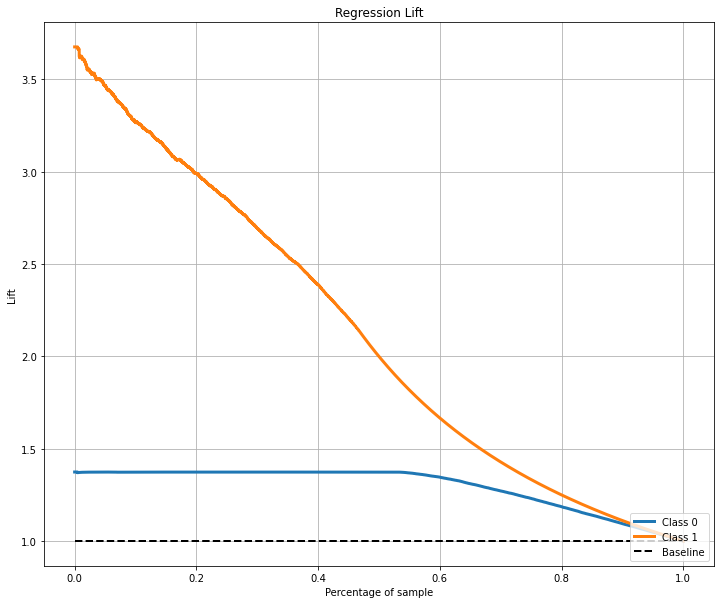

In [115]:
skplt.metrics.plot_lift_curve(y_test_cl, y_test_cl_preds, figsize=(12,10), title="Regression Lift");

In [ ]:
np.sort(y_test_cl_preds)[:10]

In [73]:
y_test_reg

228198    269083.425
240133      3578.970
163658      9497.900
176954         0.000
69498      30529.080
             ...    
239268       399.720
116033         0.000
238773     20656.470
7527      157805.390
11875        509.420
Name: total_sales, Length: 75075, dtype: float64

In [110]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [111]:
results = pd.DataFrame(data=y_test_reg.values, columns=['actual'], index=y_test_reg.index)
results['reg_preds'] = y_test_reg_preds
results['decile'] = pd.qcut(y_test_reg_preds, q=10, labels=False, retbins=False)
results['decile'] = ((results['decile']+1)*-1)+11

In [112]:
results.groupby('decile').agg({'actual':['count', 'mean'], 'reg_preds': 'mean'})

actual               reg_preds
        count        mean        mean
decile                               
1        7508 1391467.242 1615325.329
2        7506  231115.287  444134.252
3        7509   54854.597   99297.460
4        6052    2557.386   23266.379
5        8955     625.758   20860.354
6        7515    7323.122    9320.945
7        7507    6651.698  -11685.126
8        7508   10458.917  -32365.104
9        7504   18321.774  -74031.984
10       7511   71424.226 -265844.998

In [ ]:
df.groupby('dummy').agg({'returns':
                                  {'Mean': np.mean, 'Sum': np.sum}})